In [44]:
!pip install yfinance numpy pandas scikit-learn tensorflow keras-tuner scikit-optimize matplotlib

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import r2_score, explained_variance_score

import matplotlib.pyplot as plt

In [2]:
# Fetch the data
ticker_symbol = "MQG.AX"
westpac = yf.Ticker(ticker_symbol)
data = westpac.history(period="10y", interval="1wk")

In [3]:
# define target value (closing price of the next day)
data['Target'] = data['Close'].shift(-1) # -1 used to used next day's price as target


In [4]:
# add indicators

# SMA-10
data['SMA_10'] = data['Close'].rolling(window=10).mean().shift(1)
# SMA 25
data['SMA_25'] = data['Close'].rolling(window=25).mean().shift(1)

# Momentum (Close price difference shifted by 1 to use previous day's data)
data['Momentum'] = data['Close'].diff().shift(1)

# Stochastic %K and %D using data up to the previous day
low_min = data['Low'].rolling(window=14).min().shift(1)
high_max = data['High'].rolling(window=14).max().shift(1)
data['Stochastic_%K'] = ((data['Close'].shift(1) - low_min) / (high_max - low_min)) * 100
data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()

# RSI calculated from previous days
delta = data['Close'].diff(1).shift(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD calculation shifted to include only past data
exp1 = data['Close'].ewm(span=12, adjust=False).mean().shift(1)
exp2 = data['Close'].ewm(span=26, adjust=False).mean().shift(1)
macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()
data['MACD'] = macd
data['MACD_Signal'] = signal


# list of columns
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
           'Target', 'SMA_10', 'SMA_25', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI',
           'MACD', 'MACD_Signal']

# reorder columns to put 'Target' in the end
columns.remove('Target')
columns.append('Target')
data= data[columns]

print(data.head())

                                Open       High        Low      Close  \
Date                                                                    
2014-05-26 00:00:00+10:00  39.357968  39.416556  39.025972  39.078049   
2014-06-02 00:00:00+10:00  39.078051  39.442598  38.414056  39.123619   
2014-06-09 00:00:00+10:00  39.123618  39.572793  38.863229  39.045502   
2014-06-16 00:00:00+10:00  38.993422  39.833179  38.778599  39.384007   
2014-06-23 00:00:00+10:00  39.423063  39.813647  38.804636  39.357964   

                            Volume  Dividends  Stock Splits  SMA_10  SMA_25  \
Date                                                                          
2014-05-26 00:00:00+10:00  3033880        0.0           0.0     NaN     NaN   
2014-06-02 00:00:00+10:00  5598853        0.0           0.0     NaN     NaN   
2014-06-09 00:00:00+10:00  3135844        0.0           0.0     NaN     NaN   
2014-06-16 00:00:00+10:00  4558145        0.0           0.0     NaN     NaN   
2014-06-23 00:

In [5]:
data = data.dropna()

In [6]:
contains_nan = data.isna().any().any()
print("Contains NaN:", contains_nan)

num_rows_with_nan = data.isna().any(axis=1).sum()
print("Number of rows with NaN:", num_rows_with_nan)

Contains NaN: False
Number of rows with NaN: 0


In [7]:
# scale and split the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into features and target
features = scaled_data[:, :-1]
target = scaled_data[:, -1]

split_idx = int(len(features) * 0.7)
X_train = features[:split_idx]
X_test = features[split_idx:]


# Split the target into training and testing sets
y_train = target[:split_idx]
y_test = target[split_idx:]

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),  # Additional layer
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')



model.fit(X_train, y_train, epochs=50, batch_size=50, verbose=1)

Epoch 1/50


C:\Users\Kirill\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1414  
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7244e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9955e-04 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9438e-04 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4933e-04 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5736e-04 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3114e-04 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2950e-04 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3545e-04 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7404e-04 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4369e-04 
Epoch

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_layer1', min_value=128, max_value=512, step=32),
        activation='relu',
        input_dim=X_train.shape[1]
    ))
    model.add(Dense(
        units=hp.Int('units_layer2', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(
        units=hp.Int('units_layer3', min_value=32, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dense(
        units=hp.Int('units_layer4', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mean_squared_error'
    )
    return model

# Initialize the Bayesian tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='ann_optimization'
)

# Split the data for validation during hyperparameter tuning
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Run the hyperparameter search
tuner.search(X_train_split, y_train_split, epochs=50, validation_data=(X_val, y_val), batch_size=20, verbose=1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the full training data
model.fit(X_train, y_train, epochs=50, batch_size=50, verbose=1)

In [38]:
predictions = model.predict(X_test) # MQG.AX stock

# evaluation
y_pred = predictions
 # MQG.AX stock



explained_variance = explained_variance_score(y_test, predictions)
print("Explained Variance Score:", explained_variance)


# Mean Squared Error (MSE)
mse = MeanSquaredError()
mse.update_state(y_test, y_pred)
mse_result = mse.result().numpy()
print("Mean Squared Error (MSE):", mse_result)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse_result)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = MeanAbsoluteError()
mae.update_state(y_test, y_pred)
mae_result = mae.result().numpy()
print("Mean Absolute Error (MAE):", mae_result)

# r^2
r2 = r2_score(y_test, y_pred)
print("R^2 (Coefficient of Determination):", r2)

# Calculate Mean Bias Deviation (MBD)
def mean_bias_deviation(y_true, y_pred):
    differences = y_true - y_pred
    mbd = np.mean(differences)
    return mbd

# Calculate MBD for the test set
mbd = mean_bias_deviation(y_test, y_pred)
print("Mean Bias Deviation:", mbd)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Explained Variance Score: 0.7531495201323921
Mean Squared Error (MSE): 0.0016397265
Root Mean Squared Error (RMSE): 0.040493537
Mean Absolute Error (MAE): 0.029878467
R^2 (Coefficient of Determination): 0.7452787258892236
Mean Bias Deviation: 0.0071180724643461505


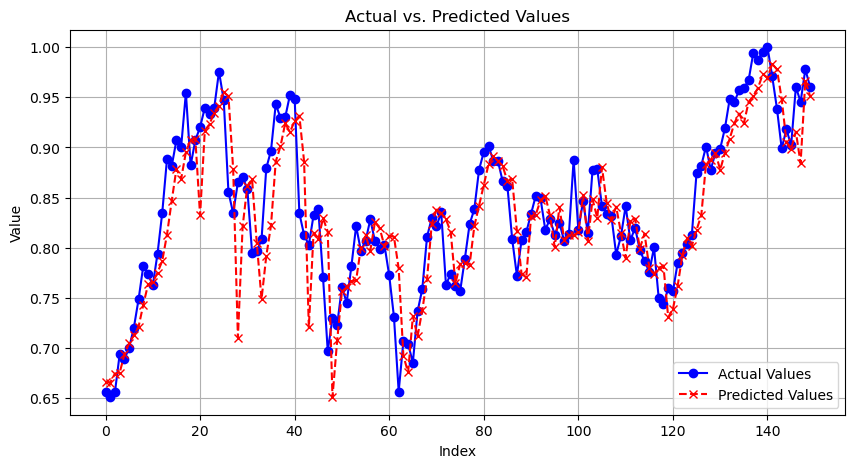

In [39]:
# plot results for macquarie group stock
y_test = np.array(y_test)
predictions = np.array(predictions)

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o')
plt.plot(range(len(predictions)), predictions, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()